In [ ]:
import torch
torch.cuda.is_available()

LCM LoRA
예시

In [ ]:
import torch
from diffusers import DiffusionPipeline, LCMScheduler

pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    variant="fp16",
    torch_dtype=torch.float16
).to("cuda")

#xFormers
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_sequential_cpu_offload()

# set scheduler
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

# load LCM-LoRA
pipe.load_lora_weights("latent-consistency/lcm-lora-sdxl")

prompt = "Self-portrait oil painting, a beautiful cyborg with golden hair, 8k"

generator = torch.manual_seed(42)
image = pipe(
    prompt=prompt, num_inference_steps=4, generator=generator, guidance_scale=1.0
).images[0]

image

  0%|          | 0/4 [00:00<?, ?it/s]

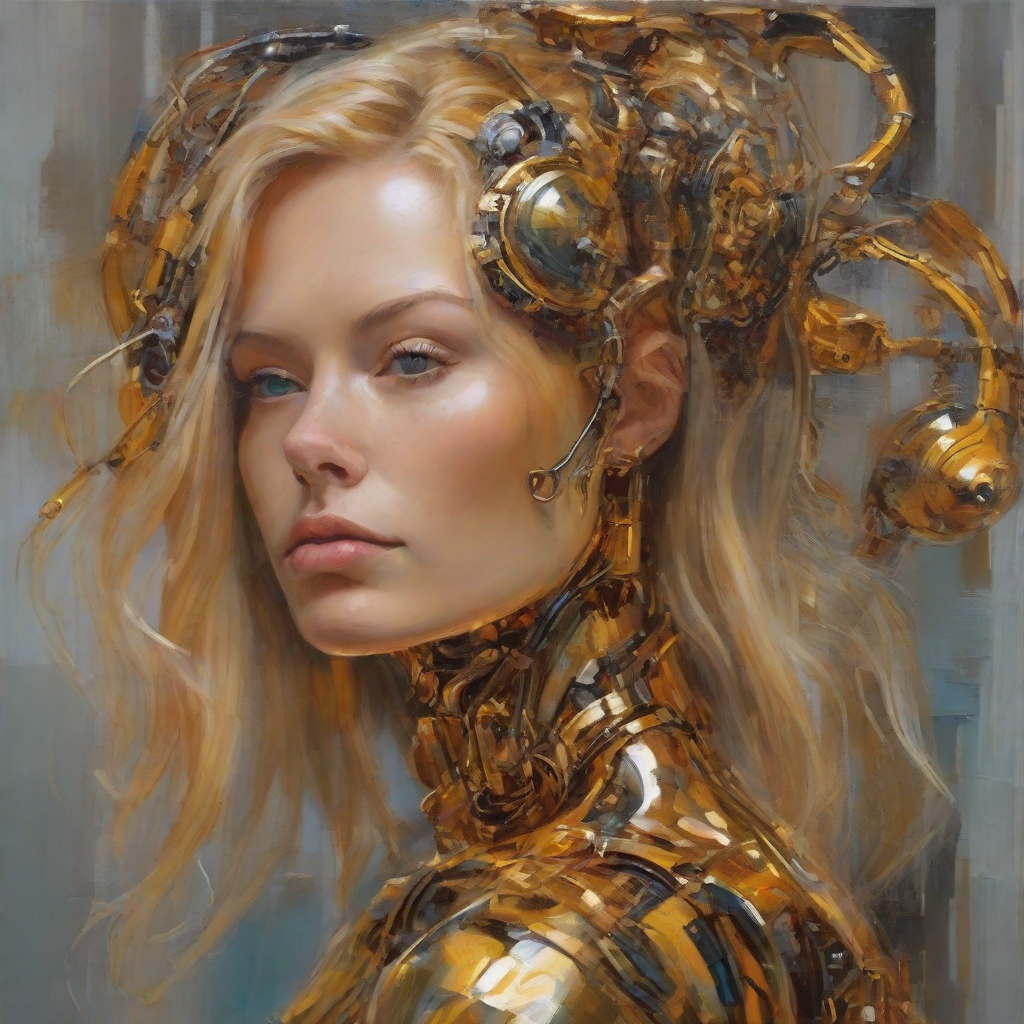

In [22]:
generator = torch.manual_seed(2)
image = pipe(
    prompt=prompt, num_inference_steps=4, generator=generator, guidance_scale=1.0
).images[0]

image

In [1]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

In [2]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [3]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [14]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.cuda.manual_seed(42) # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [15]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [16]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [17]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [18]:
2 ** (len(vae.config.block_out_channels) - 1) == 8

True

In [19]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)

In [20]:
latents = latents * scheduler.init_noise_sigma

In [21]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

In [22]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

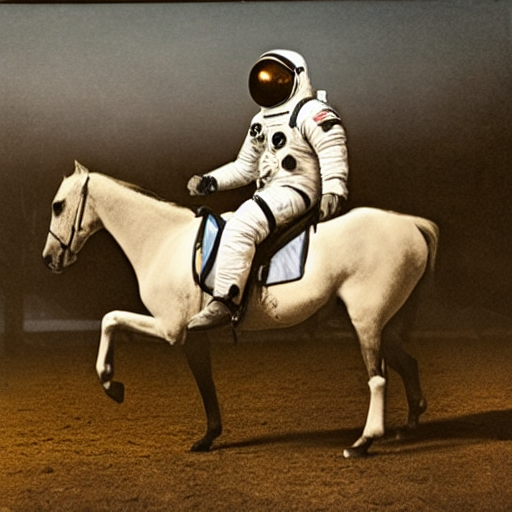

In [23]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\SSAFY\Desktop\S10P21S003\.venv\lib\site-packages\diffusers\models\attention_processor.py:1279: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(


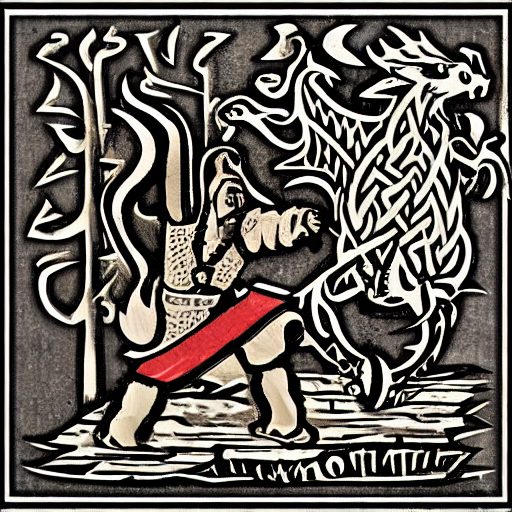

In [1]:
from diffusers import AutoPipelineForText2Image
import torch

pipeline = AutoPipelineForText2Image.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, use_safetensors=True
).to("cuda")
prompt = "peasant and dragon combat, wood cutting style, viking era, bevel with rune"

image = pipeline(prompt, num_inference_steps=25).images[0]
image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

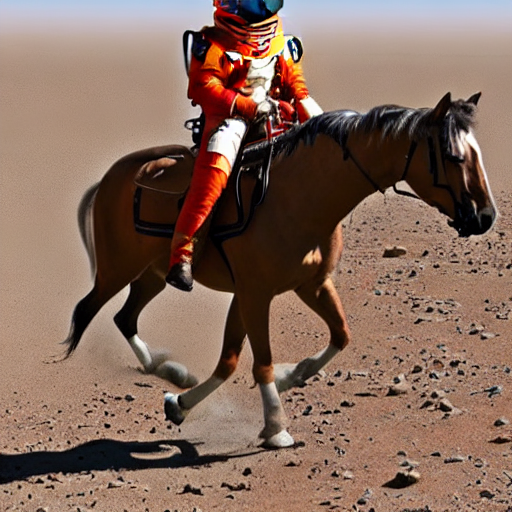

In [11]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    use_safetensors=True,
)

prompt = "a photo of an astronaut riding a horse on mars"
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_sequential_cpu_offload()

with torch.inference_mode():
    image = pipe(prompt, num_inference_steps=20).images[0]
    
image

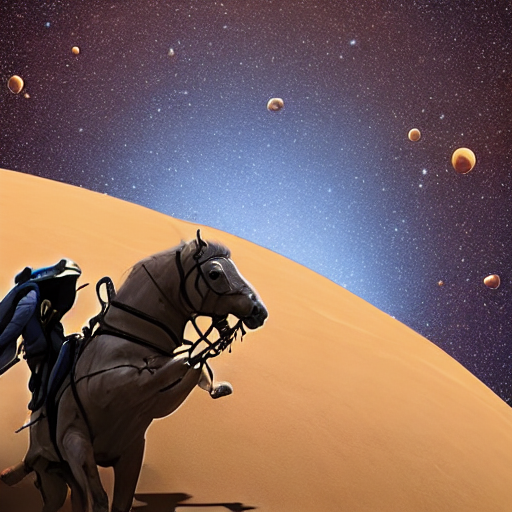

In [7]:
image

In [13]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    use_safetensors=True,
).to("cuda")

pipe.enable_xformers_memory_efficient_attention()

with torch.inference_mode():
    sample = pipe("a small cat", num_inference_steps=20)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [27]:
pipe.enable_xformers_memory_efficient_attention()
with torch.inference_mode():
    sample = pipe("man and woman in the park", num_inference_steps=20)

  0%|          | 0/20 [00:00<?, ?it/s]

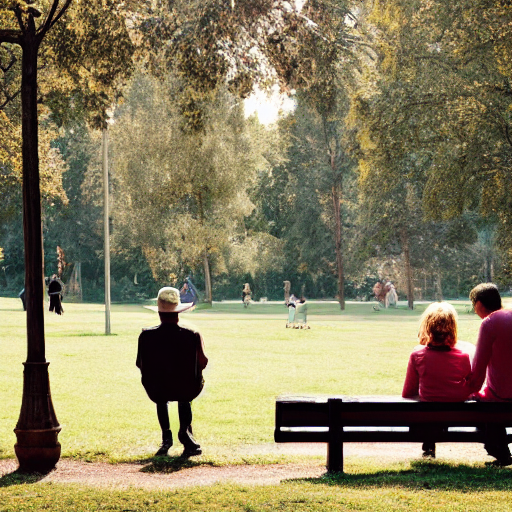

In [28]:
sample.images[0]

In [7]:
%pip install xformers

  Using cached xformers-0.0.25-cp310-cp310-win_amd64.whl.metadata (1.0 kB)
Using cached xformers-0.0.25-cp310-cp310-win_amd64.whl (208.7 MB)


In [3]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, EulerAncestralDiscreteScheduler
from transformers import CLIPTextModel
import torch

unet = UNet2DConditionModel.from_pretrained("./weights/checkpoint-3000/unet")

text_encoder = CLIPTextModel.from_pretrained("./weights/checkpoint-3000/text_encoder")

pipe = StableDiffusionPipeline.from_pretrained(
    "SG161222/Realistic_Vision_V2.0", unet=unet, text_encoder=text_encoder, dtype=torch.float32,
).to("cuda")

pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_sequential_cpu_offload()

safety_checker\model.safetensors not found
Keyword arguments {'dtype': torch.float32} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


In [24]:
#Config
prompt = " a close up portrait of sks person in front of sea, RAW photo, subject, (high detailed skin:1.2), 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3"
negative_prompt = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime:1.4), text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"
guidance_scale=7.0
seed=1
num_inference_steps=20

100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


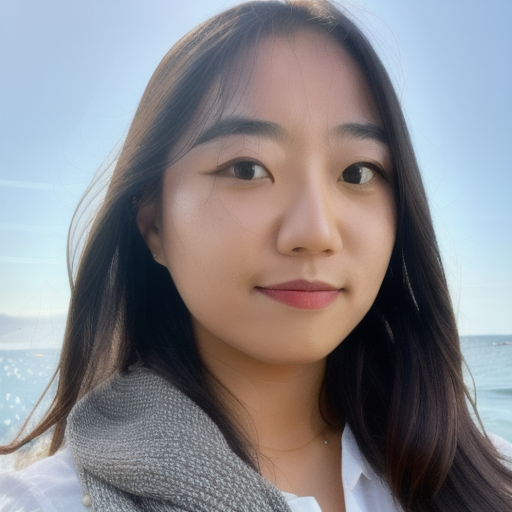

In [25]:
with torch.inference_mode():
    sample = pipe(prompt=prompt, 
                  negative_prompt=negative_prompt,
                  guidance_scale=guidance_scale,
                  seed=seed,
                  num_inference_steps=num_inference_steps)
sample.images[0]

In [11]:
sample.images[0].save(f"result/{seed}.jpg", "JPEG")

In [31]:
import random, os
import numpy


for guidance_scale in numpy.arange(5.5, 20, 0.5): # 30
    random.seed(0)
    for s in range(0, 5): # 5 개씩
        seed = random.randint(0,9999999999)
        print("CFG, Seed, Number : ", guidance_scale, seed, s)

        with torch.inference_mode():
            sample = pipe(prompt=prompt, 
                        negative_prompt=negative_prompt,
                        guidance_scale=guidance_scale,
                        seed=seed,
                        num_inference_steps=num_inference_steps)
            save_dir = f"result/{guidance_scale}"
            if not os.path.exists(save_dir) or not os.path.isdir(save_dir):
                os.mkdir(save_dir)
            save_file_name = save_dir + f"/{seed}.jpg"
            sample.images[0].save(save_file_name, "JPEG")


CFG, Seed, Number :  5.5 7921731533 0


100%|██████████| 20/20 [00:40<00:00,  2.02s/it]


CFG, Seed, Number :  5.5 1806341205 1


100%|██████████| 20/20 [00:41<00:00,  2.10s/it]


CFG, Seed, Number :  5.5 6490875490 2


100%|██████████| 20/20 [00:43<00:00,  2.17s/it]


CFG, Seed, Number :  5.5 6341935620 3


100%|██████████| 20/20 [00:41<00:00,  2.10s/it]


CFG, Seed, Number :  5.5 3900315155 4


100%|██████████| 20/20 [00:41<00:00,  2.08s/it]


CFG, Seed, Number :  6.0 7921731533 0


100%|██████████| 20/20 [00:43<00:00,  2.17s/it]


CFG, Seed, Number :  6.0 1806341205 1


100%|██████████| 20/20 [00:40<00:00,  2.04s/it]


CFG, Seed, Number :  6.0 6490875490 2


100%|██████████| 20/20 [00:43<00:00,  2.16s/it]


CFG, Seed, Number :  6.0 6341935620 3


100%|██████████| 20/20 [00:40<00:00,  2.04s/it]


CFG, Seed, Number :  6.0 3900315155 4


100%|██████████| 20/20 [00:42<00:00,  2.11s/it]


CFG, Seed, Number :  6.5 7921731533 0


100%|██████████| 20/20 [00:40<00:00,  2.03s/it]


CFG, Seed, Number :  6.5 1806341205 1


100%|██████████| 20/20 [00:40<00:00,  2.00s/it]


CFG, Seed, Number :  6.5 6490875490 2


100%|██████████| 20/20 [00:43<00:00,  2.16s/it]


CFG, Seed, Number :  6.5 6341935620 3


100%|██████████| 20/20 [00:40<00:00,  2.03s/it]


CFG, Seed, Number :  6.5 3900315155 4


100%|██████████| 20/20 [00:42<00:00,  2.12s/it]


CFG, Seed, Number :  7.0 7921731533 0


100%|██████████| 20/20 [00:41<00:00,  2.09s/it]


CFG, Seed, Number :  7.0 1806341205 1


100%|██████████| 20/20 [00:41<00:00,  2.08s/it]


CFG, Seed, Number :  7.0 6490875490 2


100%|██████████| 20/20 [00:41<00:00,  2.07s/it]


CFG, Seed, Number :  7.0 6341935620 3


100%|██████████| 20/20 [00:41<00:00,  2.09s/it]


CFG, Seed, Number :  7.0 3900315155 4


100%|██████████| 20/20 [00:37<00:00,  1.90s/it]


CFG, Seed, Number :  7.5 7921731533 0


100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


CFG, Seed, Number :  7.5 1806341205 1


100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


CFG, Seed, Number :  7.5 6490875490 2


100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


CFG, Seed, Number :  7.5 6341935620 3


100%|██████████| 20/20 [00:39<00:00,  1.99s/it]


CFG, Seed, Number :  7.5 3900315155 4


100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


CFG, Seed, Number :  8.0 7921731533 0


100%|██████████| 20/20 [00:37<00:00,  1.86s/it]


CFG, Seed, Number :  8.0 1806341205 1


100%|██████████| 20/20 [00:37<00:00,  1.87s/it]


CFG, Seed, Number :  8.0 6490875490 2


100%|██████████| 20/20 [00:40<00:00,  2.05s/it]


CFG, Seed, Number :  8.0 6341935620 3


100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


CFG, Seed, Number :  8.0 3900315155 4


100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


CFG, Seed, Number :  8.5 7921731533 0


100%|██████████| 20/20 [00:39<00:00,  1.99s/it]


CFG, Seed, Number :  8.5 1806341205 1


100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


CFG, Seed, Number :  8.5 6490875490 2


100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


CFG, Seed, Number :  8.5 6341935620 3


100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


CFG, Seed, Number :  8.5 3900315155 4


100%|██████████| 20/20 [00:42<00:00,  2.13s/it]


CFG, Seed, Number :  9.0 7921731533 0


100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


CFG, Seed, Number :  9.0 1806341205 1


100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


CFG, Seed, Number :  9.0 6490875490 2


100%|██████████| 20/20 [00:38<00:00,  1.93s/it]


CFG, Seed, Number :  9.0 6341935620 3


100%|██████████| 20/20 [00:41<00:00,  2.06s/it]


CFG, Seed, Number :  9.0 3900315155 4


100%|██████████| 20/20 [00:38<00:00,  1.93s/it]


CFG, Seed, Number :  9.5 7921731533 0


100%|██████████| 20/20 [00:37<00:00,  1.90s/it]


CFG, Seed, Number :  9.5 1806341205 1


100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


CFG, Seed, Number :  9.5 6490875490 2


100%|██████████| 20/20 [00:38<00:00,  1.92s/it]


CFG, Seed, Number :  9.5 6341935620 3


100%|██████████| 20/20 [00:40<00:00,  2.01s/it]


CFG, Seed, Number :  9.5 3900315155 4


100%|██████████| 20/20 [00:37<00:00,  1.85s/it]


CFG, Seed, Number :  10.0 7921731533 0


100%|██████████| 20/20 [00:37<00:00,  1.87s/it]


CFG, Seed, Number :  10.0 1806341205 1


100%|██████████| 20/20 [00:38<00:00,  1.90s/it]


CFG, Seed, Number :  10.0 6490875490 2


100%|██████████| 20/20 [00:41<00:00,  2.08s/it]


CFG, Seed, Number :  10.0 6341935620 3


100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


CFG, Seed, Number :  10.0 3900315155 4


100%|██████████| 20/20 [00:40<00:00,  2.05s/it]


CFG, Seed, Number :  10.5 7921731533 0


100%|██████████| 20/20 [00:39<00:00,  1.99s/it]


CFG, Seed, Number :  10.5 1806341205 1


100%|██████████| 20/20 [00:40<00:00,  2.01s/it]


CFG, Seed, Number :  10.5 6490875490 2


100%|██████████| 20/20 [00:38<00:00,  1.91s/it]


CFG, Seed, Number :  10.5 6341935620 3


100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


CFG, Seed, Number :  10.5 3900315155 4


100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


CFG, Seed, Number :  11.0 7921731533 0


100%|██████████| 20/20 [00:38<00:00,  1.92s/it]


CFG, Seed, Number :  11.0 1806341205 1


100%|██████████| 20/20 [00:37<00:00,  1.90s/it]


CFG, Seed, Number :  11.0 6490875490 2


100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


CFG, Seed, Number :  11.0 6341935620 3


100%|██████████| 20/20 [00:38<00:00,  1.93s/it]


CFG, Seed, Number :  11.0 3900315155 4


100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


CFG, Seed, Number :  11.5 7921731533 0


100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


CFG, Seed, Number :  11.5 1806341205 1


100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


CFG, Seed, Number :  11.5 6490875490 2


100%|██████████| 20/20 [00:40<00:00,  2.03s/it]


CFG, Seed, Number :  11.5 6341935620 3


100%|██████████| 20/20 [00:44<00:00,  2.22s/it]


CFG, Seed, Number :  11.5 3900315155 4


100%|██████████| 20/20 [00:40<00:00,  2.01s/it]


CFG, Seed, Number :  12.0 7921731533 0


100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


CFG, Seed, Number :  12.0 1806341205 1


100%|██████████| 20/20 [00:41<00:00,  2.06s/it]


CFG, Seed, Number :  12.0 6490875490 2


 10%|█         | 2/20 [00:03<00:33,  1.88s/it]